In [1]:
#### in this notebook, we will use compressive sensing on the real data from "Higher order interactions distort the functional landscape of microbial consortia"
import pandas as pd
import numpy as np
import cvxpy as cvx
import random
from scipy import stats
import sympy


import matplotlib.pyplot as plt
from matplotlib import pyplot

import seaborn as sns

colorlist1 = sns.color_palette("bright").as_hex()
sns.color_palette("bright")

import matplotlib.font_manager as fm

gs_font = fm.FontProperties(fname='gillsans.ttf', size=15, weight='bold')
light_grey=(0.5,0.5,0.5)

In [2]:
plt.style.use('seaborn-dark-palette')

In [102]:
### call the data file
comms = pd.read_csv("comm_mixes_dMMfits.csv")
#comms[comms["comp"]=="C-E-T"]
comms[comms["comp"]=="E-M-T"]

,well,plate,replc,comp,c.len,abs.m,abs.sd,C,E,M,...,S,T,sd.C,sd.E,sd.M,sd.P,sd.S,sd.T,Vj.fit,se
8,A07,A,1,E-M-T,3,0.121925,0.017263,NaN,200000.0,200000.0,...,NaN,8600000.0,NaN,200000.0,200000.0,NaN,NaN,1311487.7,11.095225,0.64832
9,A07,A,2,E-M-T,3,0.140575,0.007791,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.095225,0.64832


In [99]:
scheck  = pd.DataFrame(comms["T"])
scheck[scheck["T"]>0]

,T
4,3000000.00
6,180000.00
8,8600000.00
10,20000000.00
14,600000.00
20,5166666.67
26,2000000.00
32,2400000.00
36,10400000.00
38,12000000.00


In [98]:
comms[comms["comp"]=="C-E-T"]

,well,plate,replc,comp,c.len,abs.m,abs.sd,C,E,M,...,S,T,sd.C,sd.E,sd.M,sd.P,sd.S,sd.T,Vj.fit,se
46,D05,A,1,C-E-T,3,0.307125,0.047547,166666.67,166666.67,NaN,...,666666.67,NaN,166666.67,166666.67,NaN,NaN,333333.33,NaN,10.120962,0.539914
47,D05,A,2,C-E-T,3,0.119775,0.007583,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.120962,0.539914


In [4]:
allist = comms["comp"].values
### make list of all the combinations tested

In [5]:
### consider the unique combinations considered
uqlist = comms["comp"].unique()

In [6]:
### what is the index of the unique combinations?
listmatter = [] 
for k in uqlist:
    listmatter.append(list(allist).index(k))

In [7]:
### the combos aare C-E-M..., remove the hyphens
nuqlist = [i.replace('-','') for i in uqlist] 
nallist = [i.replace('-','') for i in allist] 

In [8]:
### are some communities missing in the experiments? make a list of all possible communities and compare 
bacl = ["C","E","M","P","S","T"]
from itertools import combinations
x = 'CEMPST'
thlist = [''.join(l) for i in range(len(x)) for l in combinations(x, i+1)]

In [9]:
### list of communities 
missing = []
for k in thlist :
    if k not in nallist:
        missing.append(k)

In [10]:
missing

['CES', 'CMS', 'CPS', 'CST', 'CEMS', 'CEPS', 'CEST', 'CMPS', 'CMST', 'CPST']

In [11]:
import itertools
lst = list(itertools.product([0, 1], repeat=6))

In [12]:
commsact = [] 
for k in nuqlist:
    commsact.append(thlist.index(k))

In [13]:
### generate indices for the theoretical list ### combinations of "CEMPST"
#### ordered list with corresponding binary sequences
numlist = []
for i in range(5,-1,-1):
    numlist.append(2**i)
for i in range(5,-1,-1):
    for j in range(i-1,-1,-1):
        numlist.append(2**i+2**j)
for i in range(5,-1,-1):
    for j in range(i-1,-1,-1):
        for k in range(j-1,-1,-1):
            numlist.append(2**i + 2**j + 2**k)
for i in range(5,-1,-1):
    for j in range(i-1,-1,-1):
        for k in range(j-1,-1,-1):
            for m in range(k-1,-1,-1):
                numlist.append(2**i + 2**j + 2**k + 2**m)
for i in range(5,-1,-1):
        for j in range(i-1,-1,-1):
            for k in range(j-1,-1,-1):
                for m in range(k-1,-1,-1):
                    for n in range(m-1,-1,-1):
                        numlist.append(2**i + 2**j + 2**k + 2**m+2**n)
numlist.append(63)

In [14]:
df = pd.DataFrame(thlist)
df["number"] = numlist

In [15]:
comms["comp-rem"] = nallist

In [16]:
cleaned_comm = comms.T[listmatter].T

In [17]:
listt = cleaned_comm["comp-rem"].to_list()

In [18]:
idx = [] 
for k in listt:
    if k in df[0].values:
        idx.append(list(df[0].values).index(k))

In [19]:
### the well numbers that are present in the experiments 
df["number"][idx].values

array([32, 48, 59, 41, 25, 27, 16, 55, 24, 56, 37, 22, 60, 23, 40, 20, 63,
       52, 21, 57,  8, 36, 18, 49, 19, 53,  4, 34, 17, 31,  3,  2, 33, 12,
       14,  1, 62,  6, 47, 10, 13, 28,  7, 30, 15, 61,  5,  9, 11, 44, 26,
       45, 29], dtype=int64)

In [20]:
cleaned_comm["well number"] = df["number"][idx].values

sorted_comm = cleaned_comm.sort_values(by='well number')

nscomm = sorted_comm.T.drop("Vj.fit")

nscomm.fillna(0, inplace=True)

In [21]:
vfcomm = nscomm.T[["C","E","M","P","S","T","well number","comp-rem"]]
vfcomm2 = vfcomm.copy()
vfcomm2.set_index("well number",inplace=True)

vfcomm3 = vfcomm2.copy()
### store CFUs in log 10, zeros are replaced by 0.5 
vfcomm4 = np.log10(vfcomm3[['C', 'E','M','P','S','T']].replace(0, np.nan))
vfcomm4.fillna(0,inplace=True)
vfcomm5 = vfcomm4.replace(0,0.5, method='ffill')
### store CFU in normalised form, divide by 10000
vfcomm6 =  vfcomm3[['C', 'E','M','P','S','T']].div(100000)

In [22]:
vfcomm3["total CFU"] = vfcomm3["C"] + vfcomm3["E"] + vfcomm3["M"] + vfcomm3["P"] + vfcomm3["S"] + vfcomm3["T"]
vfcomm8 = vfcomm3.copy()
for i in ["C","E","M","P","S","T"]:
    vfcomm8[i] = vfcomm8[i]/vfcomm8["total CFU"]

In [23]:
vfcomm4.to_pickle("vfcommlog.pkl")
vfcomm5.to_pickle("vfcommlogfillpt5.pkl")
vfcomm6.to_pickle("vfcommnorm.pkl")
vfcomm8.to_pickle("rel-abun-starchsanchez.pkl")

In [24]:
vfcomm3["total abundance"] = vfcomm3[["C","E","M","P","S","T"]].T.sum().values

In [25]:
vfcomm3[0] = vfcomm3["C"]/vfcomm3["total abundance"].values
vfcomm3[1] = vfcomm3["E"]/vfcomm3["total abundance"].values
vfcomm3[2] = vfcomm3["M"]/vfcomm3["total abundance"].values

vfcomm3[3] = vfcomm3["P"]/vfcomm3["total abundance"].values
vfcomm3[4] = vfcomm3["S"]/vfcomm3["total abundance"].values
vfcomm3[5] = vfcomm3["T"]/vfcomm3["total abundance"].values

In [26]:
vfcomm3.to_pickle("vfcomm-rel-cfu.pkl")

In [27]:
vfcomm3[[0,1,2,3,4,5]].to_pickle("vfcomm-rel-cfu.pkl")

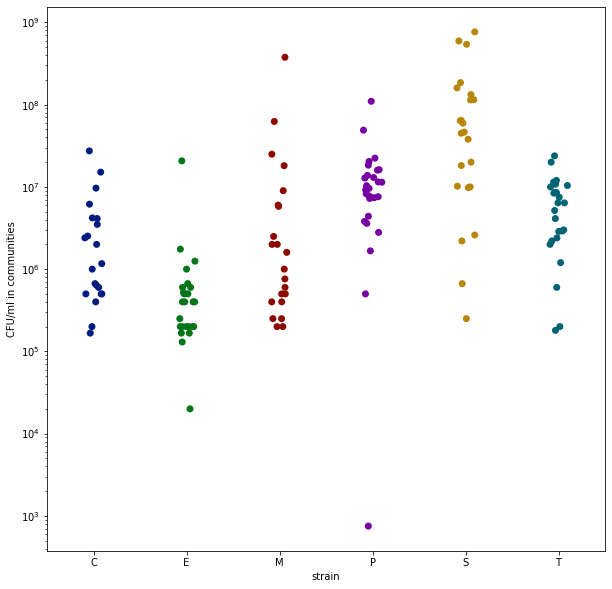

In [68]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
sns.stripplot(data=vfcomm3[["C","E","M","P","S","T"]],s=7)
pyplot.yscale("log");
plt.xlabel("strain");
plt.ylabel("CFU/ml in communities");

In [83]:
vfcomm3

,C,E,M,P,S,T,comp-rem,total CFU,total abundance,0,1,2,3,4,5
well number,,,,,,,,,,,,,,,
1,0,0,0,0,0,2912500.0,T,2912500.0,2912500.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,63750000.0,0,S,63750000.0,63750000.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0,0,250000.0,6400000.0,ST,6650000.0,6650000.0,0.0,0.0,0.0,0.0,0.037594,0.962406
4,0,0,0,750.0,0,0,P,750.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0,0,0,8250000.0,0,23875000.0,PT,32125000.0,32125000.0,0.0,0.0,0.0,0.256809,0.0,0.743191
6,0,0,0,110000000.0,59625000.0,0,PS,169625000.0,169625000.0,0.0,0.0,0.0,0.648489,0.351511,0.0
7,0,0,0,7400000.0,18200000.0,1200000.0,PST,26800000.0,26800000.0,0.0,0.0,0.0,0.276119,0.679104,0.044776
8,0,0,62500000.0,0,0,0,M,62500000.0,62500000.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0,0,250000.0,0,0,4125000.0,MT,4375000.0,4375000.0,0.0,0.0,0.057143,0.0,0.0,0.942857


In [70]:
vfcomm3[vfcomm3["comp-rem"]=="EMP"]["T"]

well number
28    10800000.0
Name: T, dtype: object

In [ ]:
listt = pd.read_pickle("starch-wells-available.pkl")
n = len(listt)

In [50]:
#### missign communities 
missingn = set(list(np.arange(1,64,1))).difference(listt)
list(missingn)

[35, 38, 39, 42, 43, 46, 50, 51, 54, 58]

In [51]:
missing

['CES', 'CMS', 'CPS', 'CST', 'CEMS', 'CEPS', 'CEST', 'CMPS', 'CMST', 'CPST']

In [52]:
### we see that CEMPT is a viable 5-sized community 
bacl = ["C","E","M","P","T"]
from itertools import combinations
x = 'CEMPT'
thlist = [''.join(l) for i in range(len(x)) for l in combinations(x, i+1)]

In [56]:
#### design matrix :
n_species1 = 6
n_species  = int(n_species1)
N = n_species 

wells = np.zeros((N,2**N),dtype=float) 

plate = pd.DataFrame(wells)
tot = 2**n_species 
form = '0'+str(n_species)+'b' 
for j in range(tot):
	y=format(j, form) 
	for i in range(n_species): 
	    plate.iat[i,j]=y[i] 
df = plate 
df = df.apply(pd.to_numeric) 
pd.to_pickle(df,"A"+str(n_species)+".pkl") 

In [58]:
pa = df.T
pa["well index"] = pa.index
pa_act = pa.T[listt].T
ones_present = [] 
ones_len = []
for i in range(6):
    ones_present.append(list(pa_act[pa_act[i]==1][i].index))
    ones_len.append(len(list(pa_act[pa_act[i]==1][i].index)))

In [60]:
### we find the well indexes in which species "S" is absent :
sansS = pa[pa[4]==0.0]
list_smallcomm = sansS["well index"].values
len(list_smallcomm[1:])

31

In [61]:
smallcomm = vfcomm2.T[list_smallcomm[1:]].T
smallcommfin = smallcomm[["C","E","M","P","T"]]

In [78]:
scomm8.T

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
C,0,0,0,0,0,0,0,0,0,0,...,666666.67,1000000.0,15125000.0,166666.67,9666666.67,2400000.0,6166666.67,2000000.0,27400000.0,4200000.0
E,0,0,0,0,0,0,0,20750000.0,500000.0,500000.0,...,0,0,1750000.0,166666.67,166666.67,400000.0,666666.67,200000.0,1000000.0,520000.0
M,0,0,0,62500000.0,250000.0,2500000.0,1000000.0,0,0,0,...,2000000.0,400000.0,0,0,0,0,25000000.0,200000.0,5800000.0,2000000.0
P,0,750.0,8250000.0,0,0,18375000.0,7250000.0,0,0,7750000.0,...,500000.0,4400000.0,0,0,10333333.33,7600000.0,0,0,12800000.0,9600000.0
T,2912500.0,0,23875000.0,0,4125000.0,0,8500000.0,0,2875000.0,0,...,0,0.0,0,0,0,11400000.0,0,12000000.0,0,2200000.0


In [81]:
scomm8 = smallcommfin.copy()
scomm8["total CFU"] = scomm8.T.sum().values
for i in ["C","E","M","P","T"]:
    scomm8[i]=scomm8[i]/scomm8["total CFU"]

In [84]:
scomm8[["C","E","M","P","T"]]

,C,E,M,P,T
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.256809,0.743191
4,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.057143,0.0,0.942857
6,0.0,0.0,0.11976,0.88024,0.0
7,0.0,0.0,0.059701,0.432836,0.507463
8,0.0,1.0,0.0,0.0,0.0
9,0.0,0.148148,0.0,0.0,0.851852
10,0.0,0.060606,0.0,0.939394,0.0


In [85]:
pasmall = pa[[0,1,2,3,5]].T[list_smallcomm[1:]]

In [86]:
pasmall.index = np.arange(0,5,1)

In [87]:
pas = pasmall.T
pas.index =  np.arange(1,32,1)
smallcommfin.index = pas.index

In [88]:
scv1 = smallcommfin.copy()
### store CFUs in log 10, zeros are replaced by 0.5 
scv2 = np.log10(scv1[['C', 'E','M','P','T']].replace(0, np.nan))
scv2.fillna(0,inplace=True)

In [100]:
scv3 = scv2.T
scv3.index = np.arange(0,5,1)
scv3[0] = [0]*5
scv4 = scv3.T

scomm7 = scomm8[["C","E","M","P","T"]].T
scomm7.index = np.arange(0,5,1)

In [101]:
scomm7[0] = [0]*5
scomm9 = scomm7.T

In [103]:
scv5 = scv4.sort_index()
scv5

scomm10 = scomm9.sort_index()
scomm10
scomm10.to_pickle("rel-cfu-starch5.pkl")

In [146]:
VH = pd.read_pickle("VH5.pkl")

In [155]:
species_ones = []
for species in range(5):
    species_ones.append(list(pas[pas[species]==1].index))

In [158]:
VH = pd.read_pickle("VH5.pkl")
FT = pd.read_pickle("FT5.pkl")

In [159]:
betact = []
for i in range(5):
    betact.append(np.dot(VH,scv5[i]))
betactdf = pd.DataFrame(betact).T

betactft = []
for i in range(5):
    betactft.append(np.dot(FT,scv5[i]))
betactftdf = pd.DataFrame(betactft).T

In [161]:
var_bge  =  pd.DataFrame((betactdf[1:32]**2).sum())
var_ft = pd.DataFrame((betactftdf[1:32]**2).sum())

In [162]:
roughnessbge = [] 
for j in range(5):
    for i in range(5):
        roughness02 = (pd.DataFrame(betactdf[j][species_ones[i]])[j]**2).sum()
        localroughness02 = roughness02/var_bge[0][j]
        roughnessbge.append([j,i,localroughness02])
        
        
roughnessft = [] 
for j in range(5):
    for i in range(5):
        roughness02 = (pd.DataFrame(betactftdf[j][species_ones[i]])[j]**2).sum()
        localroughness02 = roughness02/var_ft[0][j]
        roughnessft.append([j,i,localroughness02])

In [163]:
lrt_bge = pd.DataFrame(roughnessbge)
lrt_ft = pd.DataFrame(roughnessft)

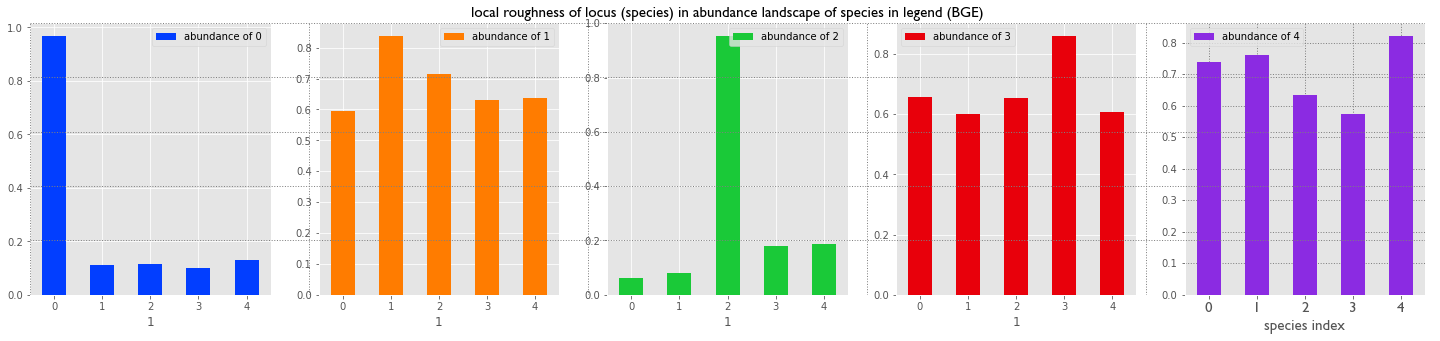

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(25,5))
for i in range(5):
    lrt_bge[lrt_bge[0]==i].plot(ax=axes[i],kind="bar",x=1,y=2,rot=False,label="abundance of "+str(i),color=colorlist1[i]);
    plt.grid(linestyle=':', linewidth=1, color='grey')
    plt.xticks(fontproperties=gs_font);
    plt.xlabel("species index",fontproperties=gs_font)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.title("local roughness of locus (species) in abundance landscape of species in legend (BGE)",fontproperties=gs_font)
plt.grid(linestyle=':', linewidth=1, color='grey')

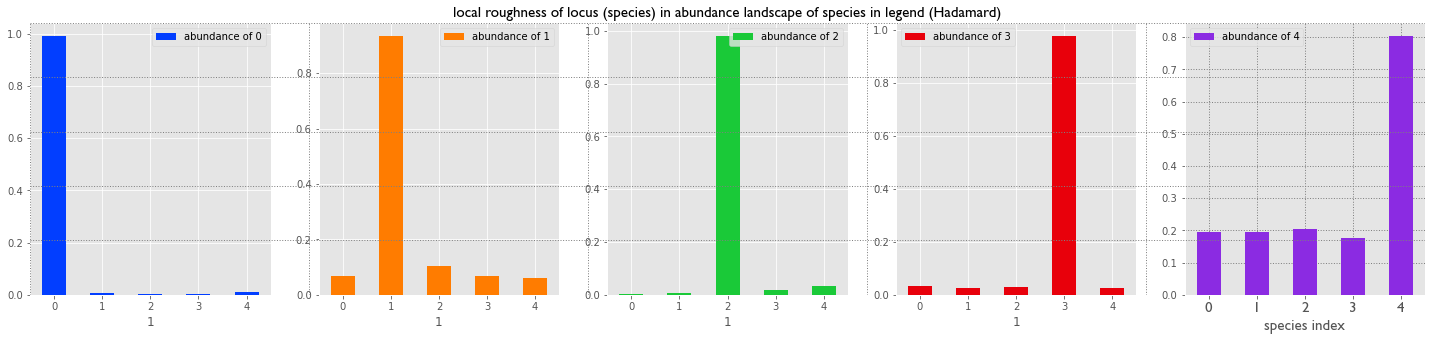

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(25,5))
for i in range(5):
    lrt_ft[lrt_ft[0]==i].plot(ax=axes[i],kind="bar",x=1,y=2,rot=False,label="abundance of "+str(i),color=colorlist1[i]);
    plt.grid(linestyle=':', linewidth=1, color='grey')
    plt.xticks(fontproperties=gs_font);
    plt.xlabel("species index",fontproperties=gs_font)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.title("local roughness of locus (species) in abundance landscape of species in legend (Hadamard)",fontproperties=gs_font)
plt.grid(linestyle=':', linewidth=1, color='grey')

In [172]:
pop_interact = []
for j in range(5):
    for i in range(5):
        m = len(list(set(species_ones[i]).intersection(species_ones[j])))
        randommm = [] 
        for iterii in range(5):
            listt = random.sample(species_ones[j],m)
            randomm = scv5[j][listt].mean()
            randommm.append(randomm)
        pop_interact.append([j,i,(scv5[j][list(set(species_ones[i]).intersection(species_ones[j]))]).mean(),randommm[0],randommm[1],randommm[2],randommm[3],randommm[4]])

In [173]:
popdf = pd.DataFrame(pop_interact)

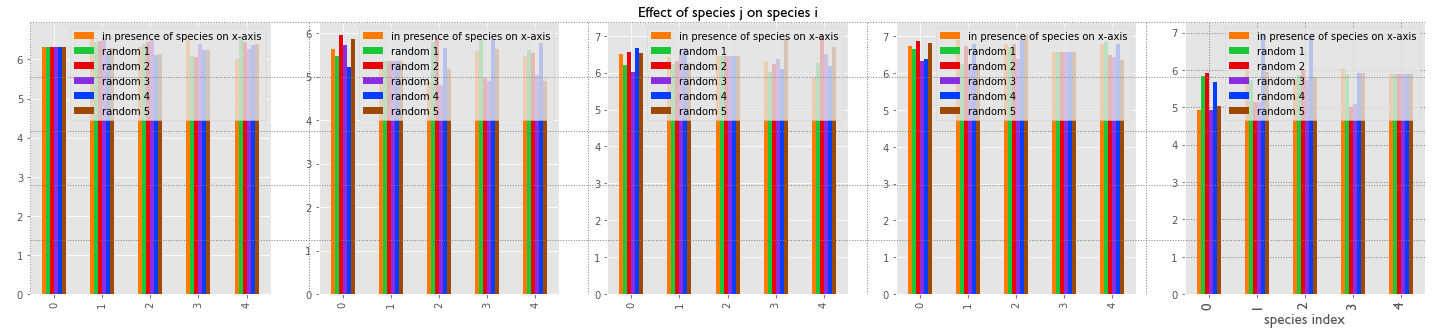

In [174]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(25,5))
for i in range(5):
    temp = popdf[popdf[0]==i]
    temp.index = np.arange(0,5,1)
    temp.plot(ax=axes[i],kind="bar",y=[2,3,4,5,6,7],label=["in presence of species on x-axis","random 1","random 2","random 3", "random 4","random 5"],color=[colorlist1[1],colorlist1[2],colorlist1[3],colorlist1[4],colorlist1[0],colorlist1[5]]);
    plt.grid(linestyle=':', linewidth=1, color='grey')
    #plt.legend(bbox_to_anchor=(1.05, 1),prop=gs_font);
    plt.xticks(fontproperties=gs_font);
    plt.xlabel("species index",fontproperties=gs_font)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.title("Effect of species j on species i",fontproperties=gs_font)
plt.grid(linestyle=':', linewidth=1, color='grey')

In [177]:
pd.to_pickle(scv5,"commCEMPT-log10-sanchez.pkl")